# Gaussian Models for Classification
### From Naive Bayes to Gaussian Mixture Model

Contents:
- Maximum Likelihood and Maximum a posterior classifiers
- Gaussian Naive Bayes
- Linear Discriminant Analysis
- Quadratic Discriminant Analysis
- Gaussian Mixture Model
- How to improve the model?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image

## Dataset
In this notebook I wanna use MAGIC Gamma Telescope Dataset. It's a Binary classification problem that has 10 real valued features. we want to classify every item as Gamma(signal) or Hadron.

### Reading the Dataset

In [3]:
features = [ 'fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist' ]
raw_data = pd. read_csv('telescope_data.csv', names=features + ['class'], skiprows=1)

In [4]:
raw_data

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g
...,...,...,...,...,...,...,...,...,...,...,...
19015,21.3846,10.9170,2.6161,0.5857,0.3934,15.2618,11.5245,2.8766,2.4229,106.8258,h
19016,28.9452,6.7020,2.2672,0.5351,0.2784,37.0816,13.1853,-2.9632,86.7975,247.4560,h
19017,75.4455,47.5305,3.4483,0.1417,0.0549,-9.3561,41.0562,-9.4662,30.2987,256.5166,h
19018,120.5135,76.9018,3.9939,0.0944,0.0683,5.8043,-93.5224,-63.8389,84.6874,408.3166,h


### Encode class labels

In [5]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(raw_data['class'])
raw_data['class'] = le.transform(raw_data['class'])
X = raw_data[features].values
y = raw_data['class'].values

### Checking class imbalance

<AxesSubplot:ylabel='Frequency'>

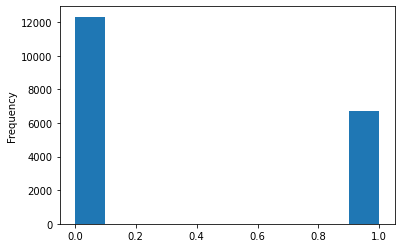

In [6]:
raw_data['class'].plot.hist()

As you can see dataset is not balanced, hence for evaluating the model in addition to accuracy we'll also check the f1-score

### Create the train and test sets

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

It is better to write a function for easier evaluation of the classifiers. 

In [8]:
def evaluate_clf(X_train, X_test, y_train, y_test, clf, name="Classifier"):
  from sklearn.metrics import f1_score, accuracy_score
  # fit the classifier
  clf.fit(X_train, y_train)
  pred = clf.predict(X_test)
  # evaluate prediction using acc and f1 score
  score_f1 = f1_score(y_test, pred)
  score_acc = accuracy_score(y_test, pred)
  print('{} acc-score: {}'.format(name, score_acc))
  print('{} f1-score: {}'.format(name, score_f1))

## Define The Enemy!
Decision Tree is an Excellent classifier. First we'll evaluate it's performance then try to beat it by using Gaussian models.

In [8]:
from sklearn.tree import DecisionTreeClassifier
evaluate_clf(X_train, X_test, y_train, y_test, DecisionTreeClassifier(), "Decision Tree")

Decision Tree acc-score: 0.8080967402733964
Decision Tree f1-score: 0.7290274684484037


## Maximum Likelihood and Maximum a Posterior Classifiers
If you can find a proper probability distribution for every class, then you can calculate the likelihood of a new data item and find the class for which the likelihood is maximum. Sometimes you have a prior knowledge about you classes and you can encode it as prior distributions. In this notebook we use Multivariate Normal or Gaussian Distribution for modeling density of classes. We will start by a simple model later we'll improve it until out performing the Decision Tree classifier.


## Gaussian Naive Bayes Classifier
Let's start by a simple Gaussian model. In this model we assume that the features are independent. That means a diagonal covariance matrix for each Gaussian distribution. Because of the assumption of feature inedpendence it's called Naive. 

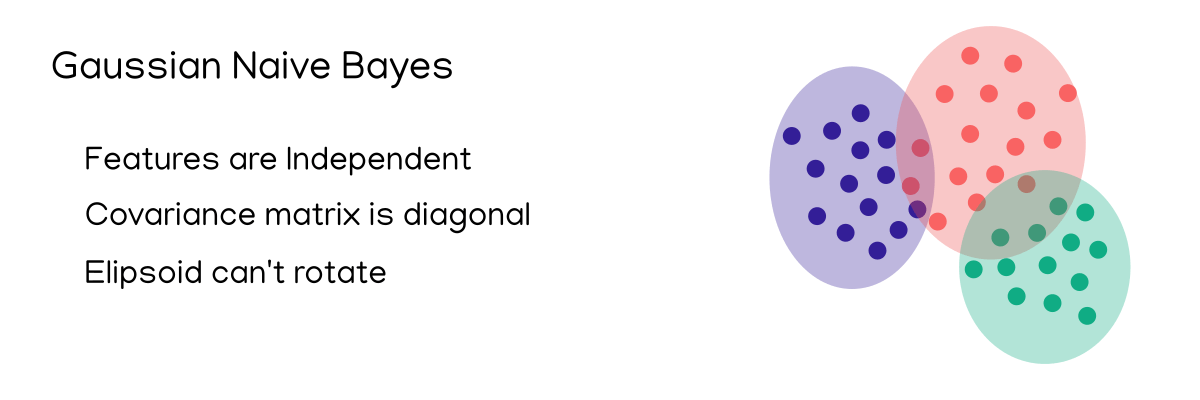

In [9]:
Image('../input/gaussiannotebookimg/2.png')

In [10]:
from sklearn.naive_bayes import GaussianNB
evaluate_clf(X_train, X_test, y_train, y_test, GaussianNB(), "Gaussian NB")

Gaussian NB acc-score: 0.7245005257623555
Gaussian NB f1-score: 0.48526522593320237


Well, in comparison to Decision Tree result it's disappointing. But we can improve it. Before that, we must know what's the problem.

### Why Gaussian Naive Bayes doesn't perform well?
In this case that's mainly because of the assumption that indicates features are independent.
From the geometrical point of view it means the elipsoid of Normal ditribution can not rotate and only can be scaled along it's axes.
To understand better, let's check the correlation of features.

In [11]:
raw_data[features].corr()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist
fLength,1.000000,0.770512,0.702454,-0.630999,-0.598145,-0.368556,-0.119747,0.013389,-0.008777,0.418466
fWidth,0.770512,1.000000,0.717517,-0.609779,-0.581141,-0.266961,-0.176234,0.039744,0.066061,0.336816
fSize,0.702454,0.717517,1.000000,-0.850850,-0.808835,-0.159863,0.095157,0.015455,-0.186675,0.437041
fConc,-0.630999,-0.609779,-0.850850,1.000000,0.976412,0.112272,-0.121899,-0.011294,0.235272,-0.328332
fConc1,-0.598145,-0.581141,-0.808835,0.976412,1.000000,0.100159,-0.118769,-0.010966,0.229799,-0.304625
fAsym,-0.368556,-0.266961,-0.159863,0.112272,0.100159,1.000000,0.274045,0.002553,-0.055689,-0.206730
fM3Long,-0.119747,-0.176234,0.095157,-0.121899,-0.118769,0.274045,1.000000,-0.017197,-0.186275,0.037025
fM3Trans,0.013389,0.039744,0.015455,-0.011294,-0.010966,0.002553,-0.017197,1.000000,0.004659,0.011427
fAlpha,-0.008777,0.066061,-0.186675,0.235272,0.229799,-0.055689,-0.186275,0.004659,1.000000,-0.220556
fDist,0.418466,0.336816,0.437041,-0.328332,-0.304625,-0.206730,0.037025,0.011427,-0.220556,1.000000


We can see some features are highly correlated. for example see the scatter plot for **fSize**
and **fConc**

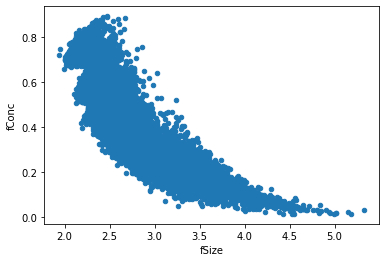

In [12]:
raw_data[features].plot.scatter('fSize', 'fConc')

### How to fix the feature correlation problem?
In Naive Bayes model, Covariance Matrix of Normal ditributions of classes was diagonal. Instead, we can use a full Covariance Matrix, But for now let's use a unique Covariance Matrix for each class. Indeed we assume that the correlation of features for every class is same. Such a model is called *LDA* or *Linear Discriminant Analysis*.

## Linear Discriminant Analysis (LDA)

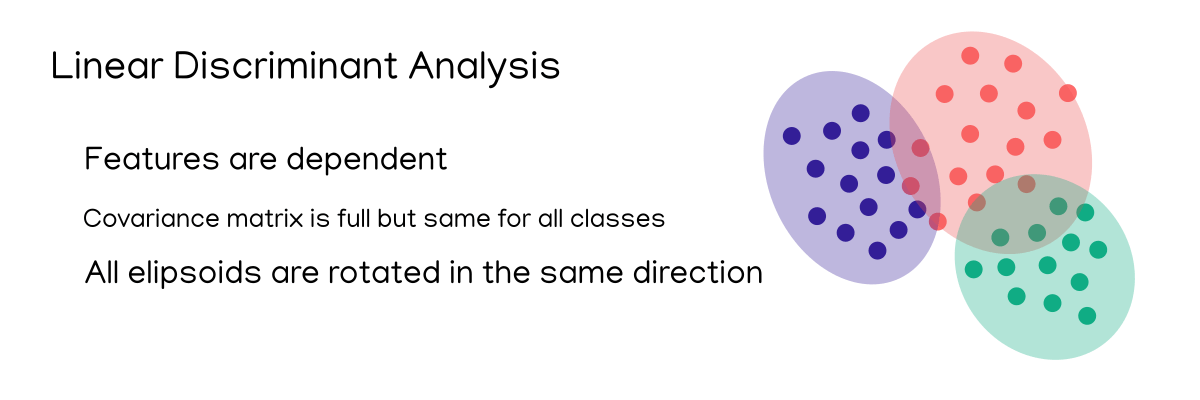

In [13]:
Image('../input/gaussiannotebookimg/3.png')

### Performing LDA

In [14]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
evaluate_clf(X_train, X_test, y_train, y_test, LinearDiscriminantAnalysis(), "LDA")

LDA acc-score: 0.7835611636873466
LDA f1-score: 0.6448087431693988


Much better than Naive Bayes but still worse than Decision Tree.

### Why not to use different Covariance Matrices?
We can do so, However if we have many classes, it will increase the number of parameters significantly and can lead to overfittig. This method is called *Quadratic Discriminant Analysis*  or *QDA*.

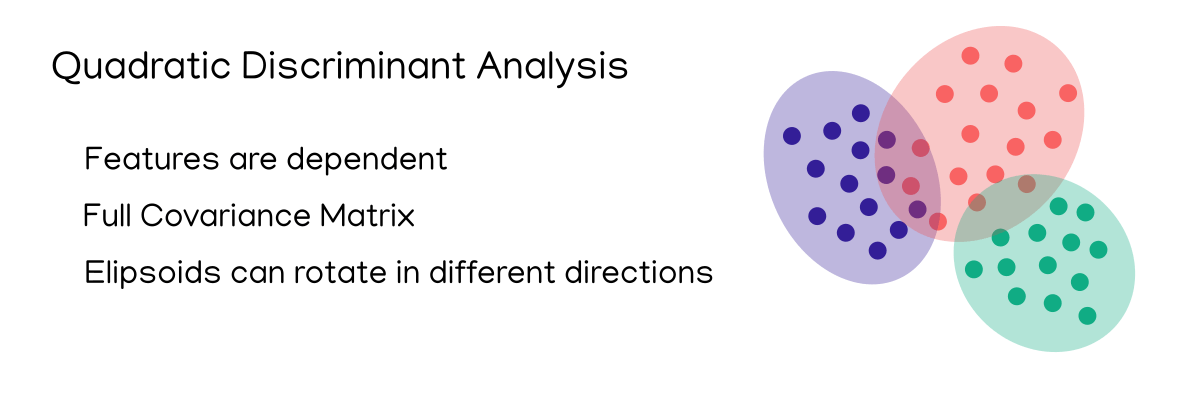

In [15]:
Image('../input/gaussiannotebookimg/4.png')

### QDA Result

In [16]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
evaluate_clf(X_train, X_test, y_train, y_test, QuadraticDiscriminantAnalysis(), "QDA")

QDA acc-score: 0.7835611636873466
QDA f1-score: 0.61175730902232


### Why LDA result was better?
It seems for this dataset, increaing flexibility of Normal distribution doesn't have a big impact on performance and instead caused overfitting. Unfortunately Decision Tree is still better. let's find another way.

### So, Now how to improve the model?
By far, for every class we used one Normal Distribution. If that's not enough let's use more of them. We can use a convex combination of them! this is called Gaussian Mixture Model.

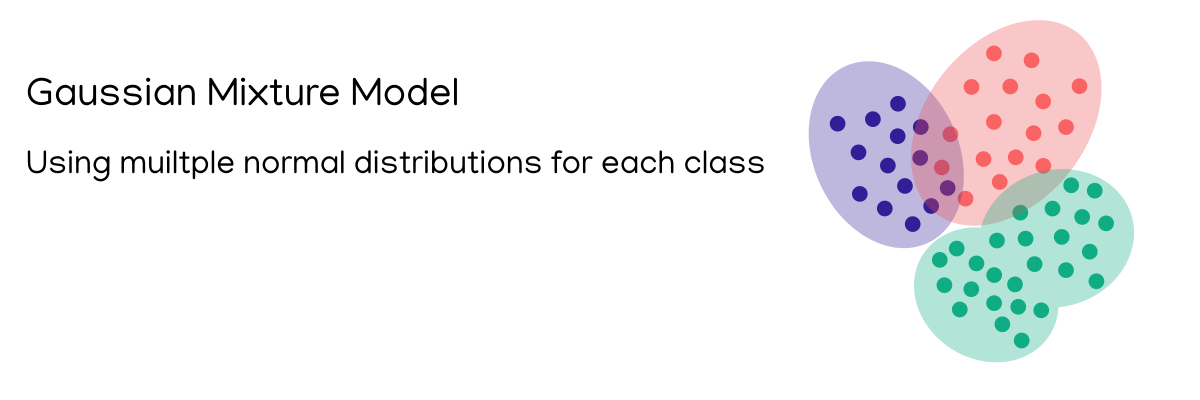

In [17]:
Image('../input/gaussiannotebookimg/5.png')

### Expectation Maximization Algorithm
Estimating parameters of a single Gaussian distribution is trivial and includes only calculation of mean and covariance.However parameter estimation for a Gaussian Mixture model is not so trivial. Also optimizing parameters of these models for minimizing the negative log likelihood is not easy for gradient-based optimizers. that's because the Covariance Matrix should be Positive-definite which is not an easy to handle constraint for many optimizers [2]. Instead we can use the Expectation Maximization Algorithm. Usually used for estimating parameters of Graphical models who use latent variables (in our case coefficients of gaussian distributions). Fortunately EM algorithm for Gaussian Mixture model has been implemented in Scikit-learn, hence there is no need to implement it manually, However implementing EM is not hard at all. for details of EM see the reference [1]. 

### Creating a Scikit-Learn classifier based on Gaussian Mixture 
Now we use scikit implementation of EM Algorithm for Gaussian Mixture models to create a custom estimator for classification.

In [18]:
from sklearn.base import BaseEstimator
from sklearn.mixture import GaussianMixture

class GaussianMixtureClassifier(BaseEstimator):
  
  def __init__(self, n_components=1):
    self.n_components = n_components

  def fit(self, X, y):
    # find number of classes
    self.n_classes = int(y.max() + 1)
    # create a GM for each class
    self.gm_densities = [GaussianMixture(self.n_components, covariance_type='full') for _ in range(self.n_classes)]
    # fit the Mixture densities for each class
    for c in range(self.n_classes):
      # find the correspond items
      temp = X[np.where(y == c)]
      # estimate density parameters using EM
      self.gm_densities[c].fit(temp)

  def predict(self, X):
    # calculate log likelihood for each class
    log_likelihoods = np.hstack([ self.gm_densities[c].score_samples(X).reshape((-1, 1)) for c in range(self.n_classes) ])
    # return the class whose density maximizes the log likelihoods
    log_likelihoods = log_likelihoods.argmax(axis=1)
    return log_likelihoods

Now, we create a Gaussian Mixture Classifier with a mixture of 2 Gaussian distributions per class.

In [19]:
evaluate_clf(X_train, X_test, y_train, y_test, GaussianMixtureClassifier(n_components=2), "Gaussian Mixture")

Gaussian Mixture acc-score: 0.8538380651945321
Gaussian Mixture f1-score: 0.784273150543197


### Finally we beated the Decision Tree!!!
Now you can see the mixture model outperforms the Decision Tree.

## How to improve the result further?
- Encode your domain knowledge about the problem as prior distributions.
- Try optimizing hyperparameters of the model, number of Gaussians for each class, Covariance Matrix type for each class.
- Everything is not Gaussian. again use your domain knowledge and find proper distribution for each feature.
- Do a little feature engineering

## References
These resources help me a lot to write this notebook.  
- [1] Machine Learning: A Probabilistic Perspective, Kevin P. Murphy  
See Chapter 4 for Gaussian Models and Chapter 11 for Mixture Models and EM Algorithm  
- [2] Coursera, Advanced Machine Learning Specialization, Bayesian Methods for Machine Learning Course

I will be happy to know your comments :)